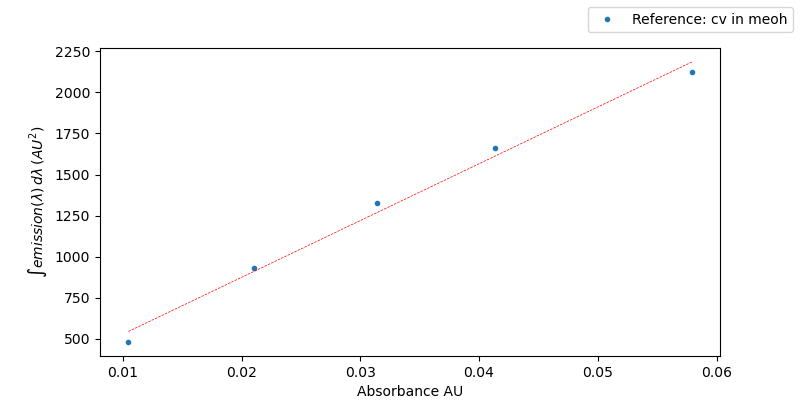

In [1]:
import resources as r
from resources.deconvoluteFuncs import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from sklearn.metrics import r2_score
from IPython.display import HTML, display, clear_output
import logging
import warnings
warnings.simplefilter('ignore', np.RankWarning)


%matplotlib ipympl
# %matplotlib inline
%config InlineBackend.figure_format='svg'
layout = widgets.Layout(width='50%')

display(HTML('''<style>
    .widget-label { min-width: 30ex !important; }
</style>'''))

log = logging.getLogger()

fluorophores, solvents, methods = r.fluorophores_solvents_methods()

def loadSpectrum(logLevel:int, fluorophoreList:list[r.Fluorophores], solventList:list[r.Solvents], 
                 spectraList:list[r.spectraType], plotGaussians:bool, printGaussians:bool,
                 printlmax:bool, printConc:bool, norm:str, units:str, gaussAmps:tuple[float,float]):
    clear_output() 
    log.setLevel(logLevel)

    if r.spectraType.qy in spectraList:
        fig2, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
        ax1.axhline(0, c='k', lw=0.5)
        ax2.axhline(0, c='k', lw=0.5)
        ax1.set_ylabel("Absorbance (AU)")
        ax1.set_xlabel("λ (nm)")
        ax2.set_ylabel("Emission (AU)")
        ax2.set_xlabel("λ (nm)")
        for fluorophore in fluorophoreList:
            for solvent in solventList:
                for spectraType in spectraList:
                    if spectraType == r.spectraType.qy:
                        with r.statusLoad('spectra') as df:
                            with r.statusLoad('qy_ref') as df_qy:
                                spectrum = None
                                try:
                                    spectrum = df.at[(fluorophore, spectraType), solvent]
                                except KeyError:
                                    try:
                                        spectrum = df_qy.at[(fluorophore, spectraType), solvent]
                                    except KeyError:
                                        log.warning(f'{fluorophore}: {solvent} {spectraType} spectrum not imported. Skipping...')
                                if spectrum != None:
                                    for basicSpectrum in spectrum.absorbanceSpectra:
                                        ax1.plot(basicSpectrum.x, basicSpectrum.y)

                                    for basicSpectrum in spectrum.emissionSpectra:
                                        ax2.plot(basicSpectrum.x, basicSpectrum.y)
                                else:
                                    log.warning(f'{fluorophore}: {solvent} {spectraType} spectrum not imported. Skipping...')
        display(plt.show())
        del fig2

    printed = False
    if r.spectraType.absorbance in spectraList or r.spectraType.emission in spectraList:
        fig, ax = plt.subplots(1,1, figsize=(8,4))
        ax.axhline(0, c='k', lw=0.5)
        with r.statusLoad('spectra') as df:
            for fluorophore in fluorophoreList:
                for solvent in solventList:
                    for spectraType in spectraList:
                        if spectraType != r.spectraType.qy:
                            try:
                                spectrum = df.at[(fluorophore, spectraType), solvent]
                                if spectrum == None:
                                    log.warning(f'{fluorophore}: {solvent} {spectraType} spectrum not imported. Skipping...')
                                else:
                                    print(f'{fluorophore} in {solvent}')
                                    x = spectrum.x
                                    if units == 'eV': x = r.nmToEv(x)

                                    y = spectrum.y
                                    if norm == 'Normalise':
                                        y = np.divide(y, np.linalg.norm(y))
                                    elif norm == 'Equal λmax':
                                        y = np.divide(y, np.max(y))
                                        

                                    ax.plot(x, y, label=f'{fluorophore}: {solvent} {spectraType}')
                                    if printlmax:
                                        maxList = y.max(keepdims=1) == y
                                        maxVal = [i for i, j in zip(x, maxList) if j == True]
                                        print(f'{fluorophore}: {solvent} {spectraType} λmax = {maxVal[0]:.3f}')

                                    if plotGaussians:
                                        if units == 'eV':
                                            print(f'\n{spectraType}')
                                        peaksFunc = {r.spectraType.emission: spectrum.peaks_sorted_reverse,
                                                    r.spectraType.excitation: spectrum.peaks_sorted_forward,
                                                    r.spectraType.absorbance: spectrum.peaks_sorted_forward}
                                        for gauss in peaksFunc[spectraType]:
                                            amp = gauss.amplitude
                                            if norm == 'Equal λmax':
                                                amp = amp*(np.linalg.norm(spectrum.y)/np.max(spectrum.y))
                                            elif norm == 'None':
                                                amp = amp*np.linalg.norm(spectrum.y)

                                            if units == 'nm' and printed == False: 
                                                log.critical('Since gaussians are symmetrical, they cannot be plotted on the λ scale\ndue to the nonlinear e = hc/λ relationship')
                                                printed = True
                                            elif units == 'eV':
                                                if amp >= gaussAmps[0] and amp <= gaussAmps[1]:
                                                    ax.fill_between(x, gaussian_func(x, amp, gauss.center, gauss.width), alpha=0.3)
                                                if printGaussians and amp >= gaussAmps[0] and amp <= gaussAmps[1]:
                                                    print(f'Gauss - loc: {gauss.center:.3f} eV ({r.evToNm(gauss.center):.0f} nm) amp: {amp:.3f}  width: {gauss.width:.3f}')
                                                
                                    if spectraType == r.spectraType.absorbance and printConc:
                                        print(f'Concentration of {fluorophore} in {solvent} is {(max(spectrum.y)/fluorophore.extinction)*1e6:.3f} μM from {max(spectrum.y):.3f} AU')
                            except KeyError:
                                log.warning(f'{fluorophore}: {solvent} {spectraType} spectrum not imported. Skipping...')
        ax.set_ylabel("Absorbance/Emission")
        ax.set_xlabel(f"λ ({units})")
        if units == 'eV': ax.invert_xaxis()
        fig.legend()
        plt.show()

def printDS():
    clear_output() 
    with r.statusLoad('dataset') as df:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(df.style.applymap(lambda x: 'color : blue' if x != None  else 'color : red').format(precision=3))

    with r.statusLoad('spectra') as df:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(df.notnull().style.applymap(lambda x: 'color : blue' if x == True  else 'color : red'))

    with r.statusLoad('qy_ref') as df:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(df.notnull().style.applymap(lambda x: 'color : blue' if x == True  else 'color : red'))

def loadFromDS(fluorophore:r.Fluorophores, solvent:r.Solvents):
    with r.statusLoad('dataset') as df:
        a = df.at[(fluorophore, 'a'), solvent]
        e = df.at[(fluorophore, 'e'), solvent]
        a_g = df.at[(fluorophore, 'a_g'), solvent]
        e_g = df.at[(fluorophore, 'e_g'), solvent]
        zz = df.at[(fluorophore, 'zz'), solvent]
        zz_g = df.at[(fluorophore, 'zz_g'), solvent]
        conc = df.at[(fluorophore, 'conc'), solvent]
    fluorophoreWidget=widgets.Dropdown(options=fluorophores, value=fluorophore, description='Fluorophore', disabled=True)
    fluorophoreWidget.layout.display = "none"
    solventWidget=widgets.Dropdown(options=solvents, value=solvent, description='Solvents', disabled=True)
    solventWidget.layout.display = "none"

    display(widgets.interactive(saveToDS, {'manual' : True, 'manual_name' : 'Save to Dataset'},
                                aE = widgets.FloatText(value=a, description='ΔE λmax Abs', step=0.01),
                                a_gE = widgets.FloatText(value=a_g, description='Max Gaussian Abs', step=0.01),
                                eE = widgets.FloatText(value=e, description='ΔE λmax Em', step=0.01),
                                e_gE = widgets.FloatText(value=e_g, description='Max Gaussian Em', step=0.01),
                                zzE = widgets.FloatText(value=zz, description='ΔE 0-0', step=0.01),
                                zz_gE = widgets.FloatText(value=zz, description='ΔE 0-0 (From Gaussians)', step=0.01),
                                conc_in = widgets.FloatText(value=conc, description='ΔE 0-0 (From Gaussians)', step=0.01),
                                fluorophore=fluorophoreWidget, solvent=solventWidget))

def loadFromDSQY(fluorophore:r.Fluorophores, solvent:r.Solvents):
    with r.statusLoad('dataset') as df:
        qy = df.at[(fluorophore, 'qy'), solvent]

    fluorophoreWidget=widgets.Dropdown(options=fluorophores, value=fluorophore, description='Fluorophore', disabled=True)
    fluorophoreWidget.layout.display = "none"
    solventWidget=widgets.Dropdown(options=solvents, value=solvent, description='Solvents', disabled=True)
    solventWidget.layout.display = "none"

    display(widgets.interactive(saveToDSQY, {'manual' : True, 'manual_name' : 'Save to Dataset'},
                                qy_widg = widgets.FloatText(value=qy, description='Quantum Yield', step=0.01),
                                fluorophore=fluorophoreWidget, solvent=solventWidget))

def saveToDS(fluorophore:r.Fluorophores, solvent:r.Solvents, aE:float, eE:float, a_gE:float, e_gE:float, zzE:float, zz_gE:float, conc_in:float):
    with r.statusLoad('dataset') as df:
        df.at[(fluorophore, 'a'), solvent] = aE
        df.at[(fluorophore, 'e'), solvent] = eE
        df.at[(fluorophore, 'a_g'), solvent] = a_gE
        df.at[(fluorophore, 'e_g'), solvent] = e_gE
        df.at[(fluorophore, 'zz'), solvent] = zzE
        df.at[(fluorophore, 'zz_g'), solvent] = zz_gE
        df.at[(fluorophore, 'conc'), solvent] = conc_in
        print(f'Saved {fluorophore} in {solvent}!')

def saveToDSQY(fluorophore:r.Fluorophores, solvent:r.Solvents, qy_widg:float):
    with r.statusLoad('dataset') as df:
        df.at[(fluorophore, 'qy'), solvent] = qy_widg

        print(f'Saved {fluorophore} in {solvent}!')

def spectrumToSeries(spectrum:r.spectrumSeries, zero:bool):
    absList = []
    fluorList = []
    for absSpectrum, fluorSpectrum in zip(spectrum.absorbanceSpectra, spectrum.emissionSpectra):
        absLoc = np.round(absSpectrum.x).tolist().index(spectrum.excitation)
        absList += [absSpectrum.y[absLoc]]
        fluorList += [fluorSpectrum.integrand]

    if zero:
        absList += [0]
        fluorList += [0]

    coef = np.polyfit(absList, fluorList, 1)
    return coef, absList, fluorList

def loadQYSpectrum(logLevel:int, fluorophoreList:list[r.Fluorophores], solventList:list[r.Solvents], 
                 refFluorophore:r.Fluorophores, refSolvent:r.Solvents, zero:bool) -> None:
    log.setLevel(logLevel)
    clear_output()
    refOK = False
    with r.statusLoad('spectra') as df:
        with r.statusLoad('qy_ref') as df_qy:
            try:
                if refFluorophore in fluorophores:
                    refSpectrum = df.at[(refFluorophore, r.spectraType.qy), refSolvent]
                    with r.statusLoad('dataset') as df_energy:
                        refQY = df_energy.at[(refFluorophore, 'qy'), refSolvent]
                        if refQY == None:
                            refQY = refSpectrum.qy
                else: 
                    refSpectrum = df_qy.at[(refFluorophore, r.spectraType.qy), refSolvent]
                    refQY = refSpectrum.qy
                refOK = True
            except KeyError:
                log.critical(f'Reference spectra {refFluorophore} in {refSolvent} not found!')
            except AttributeError:
                log.critical(f'Reference spectra {refFluorophore} in {refSolvent} not found!')

            if refOK:
                fig, ax = plt.subplots(1,1, figsize=(8,4))
                refCoef, absList, fluorList = spectrumToSeries(refSpectrum, zero)
                poly1d_fn = np.poly1d(refCoef) 
                ax.plot(absList, fluorList, '.', label=f'Reference: {refFluorophore} in {refSolvent}')
                ax.plot(absList, poly1d_fn(absList), '--r', lw=0.5)
                r2 = r2_score(fluorList, poly1d_fn(absList))
                print(f'Φ for {refFluorophore} in {refSolvent}: {refQY:.3f} (R^2: {r2:.3f}) ← Reference')

                for fluorophore in fluorophoreList:
                    for solvent in solventList:
                        fluorophoreOK = False
                        try:
                            spectrum = df.at[(fluorophore, r.spectraType.qy), solvent]
                            if type(spectrum) == r.spectrumSeries: fluorophoreOK = True
                        except KeyError:
                            try:
                                spectrum = df_qy.at[(fluorophore, r.spectraType.qy), solvent]
                                if type(spectrum) == r.spectrumSeries: fluorophoreOK = True
                            except KeyError:
                                log.warning(f'{fluorophore}: {solvent} spectra not imported. Skipping...')
                        if fluorophoreOK:
                            coef, absList, fluorList = spectrumToSeries(spectrum, zero)
                            poly1d_fn = np.poly1d(coef) 
                            ax.plot(absList, fluorList, '.', label=f'{fluorophore} in {solvent}')
                            ax.plot(absList, poly1d_fn(absList), '--k', lw=0.5)
                            qy = refQY*(coef[0]/refCoef[0])*((solvent.n**2)/(refSolvent.n**2))
                            r2 = r2_score(fluorList, poly1d_fn(absList))
                            print(f'Φ for {fluorophore} in {solvent}: {qy:.3f} (R^2: {r2:.3f})')
                        else:
                            log.warning(f'{fluorophore}: {solvent} spectra not imported. Skipping...')
    if refOK:
        ax.set_ylabel(r"$\int emission(\lambda)\:d\lambda\:(AU^2)$")
        ax.set_xlabel("Absorbance AU")
        fig.legend()
        plt.show()

def expFunc(t, I0, d, b, τ) -> float:
    return np.add(np.multiply(np.exp(np.subtract(0, np.divide(np.subtract(t, d), τ))), I0), b)

def expWIRF(t, I0, d, b, τ, c):
    global I0_irf
    global τ_irf
    global b_irf
    global d_irf
    return np.add(expFunc(t, I0_irf, d_irf, b_irf, τ_irf), np.multiply(expFunc(t, I0, d, b, τ), c))

def expWIRFx2(t, I0, d, b, τ_1, c_1, τ_2, c_2):
    global I0_irf
    global τ_irf
    global b_irf
    global d_irf
    out = np.add(expFunc(t, I0_irf, d_irf, b_irf, τ_irf), np.multiply(expFunc(t, I0, d, b, τ_1), c_1))
    return np.add(out, np.multiply(expFunc(t, I0, d, b, τ_2), c_2))

def expWIRFx3(t, I0, d, b, τ_1, c_1, τ_2, c_2, τ_3, c_3):
    global I0_irf
    global τ_irf
    global b_irf
    global d_irf
    out = np.add(expFunc(t, I0_irf, d_irf, b_irf, τ_irf), np.multiply(expFunc(t, I0, d, b, τ_1), c_1))
    out = np.add(out, np.multiply(expFunc(t, I0, d, b, τ_2), c_2))
    return np.add(out, np.multiply(expFunc(t, I0, d, b, τ_3), c_3))

def expWIRFx4(t, I0, d, b, τ_1, c_1, τ_2, c_2, τ_3, c_3, τ_4, c_4):
    global I0_irf
    global τ_irf
    global b_irf
    global d_irf
    out = np.add(expFunc(t, I0_irf, d_irf, b_irf, τ_irf), np.multiply(expFunc(t, I0, d, b, τ_1), c_1))
    out = np.add(out, np.multiply(expFunc(t, I0, d, b, τ_2), c_2))
    out = np.add(out, np.multiply(expFunc(t, I0, d, b, τ_3), c_3))
    return np.add(out, np.multiply(expFunc(t, I0, d, b, τ_4), c_4))

def expx1(t, I0, d, b, τ, c):
    return np.multiply(expFunc(t, I0, d, b, τ), c)

def expx2(t, I0, d, b, τ_1, c_1, τ_2, c_2):
    return np.add(np.multiply(expFunc(t, I0, d, b, τ_1), c_1), np.multiply(expFunc(t, I0, d, b, τ_2), c_2))

def expx3(t, I0, d, b, τ_1, c_1, τ_2, c_2, τ_3, c_3):
    out = np.add(np.multiply(expFunc(t, I0, d, b, τ_1), c_1), np.multiply(expFunc(t, I0, d, b, τ_2), c_2))
    return np.add(out, np.multiply(expFunc(t, I0, d, b, τ_3), c_3))

def expx4(t, I0, d, b, τ_1, c_1, τ_2, c_2, τ_3, c_3, τ_4, c_4):
    out = np.add(np.multiply(expFunc(t, I0, d, b, τ_1), c_1), np.multiply(expFunc(t, I0, d, b, τ_2), c_2))
    out = np.add(out, np.multiply(expFunc(t, I0, d, b, τ_3), c_3))
    return np.add(out, np.multiply(expFunc(t, I0, d, b, τ_4), c_4))


def loadFLSpectrum(logLevel:int, fluorophoreList:list[r.Fluorophores], solventList:list[r.Solvents], 
                   xRange:float, plotData:bool, scale:bool, verbose:bool):
    # global I0_irf
    # global τ_irf
    # global d_irf
    # global b_irf
    FLFuncList = [expWIRF, expWIRF, expWIRFx2, expWIRFx3, expWIRFx4]
    FLFuncList = [expx1, expx1, expx2, expx3, expx4]
    log.setLevel(logLevel)
    clear_output()
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.axhline(0, c='k', lw=0.5)
    ax.axvline(0, c='k', lw=0.5)
    ax.set_xlabel('Time (ns)')
    ax.set_ylim(-100, 10000)
    ax.set_xlim(xRange[0], xRange[1])
    with r.statusLoad('spectra') as df:
        for fluorophore in fluorophoreList:
            for solvent in solventList:
                try:
                    spectrum = df.at[(fluorophore, r.spectraType.lifetime), solvent]
                except KeyError:
                    log.warning(f'{fluorophore}: {solvent} spectra not imported. Skipping...')
                    spectrum = None
                if spectrum != None:
                    expCount = len(spectrum.trf_fit)
                    popts = [spectrum.I0, spectrum.d, spectrum.b]
                    print(f'{fluorophore} in {solvent}:')
                    if verbose:
                        print(f'Residual: {spectrum.residual:.8f}')
                        print(f'Baseline: {spectrum.b:.2f}')
                        print(f'Δ: {spectrum.d:.2f}')
                        print(f'I0: {spectrum.I0:.0f}')
                    for trf_fit in spectrum.trf_fit:
                        popts += [trf_fit.t, trf_fit.c]
                        print(f'τ: {trf_fit.t:.2f}')
                        if verbose: print(f'Contribution: {trf_fit.c*100:.1f}%')
                    print('')
                    # I0_irf, d_irf, b_irf, τ_irf = (spectrum.irf_fit.I0, spectrum.irf_fit.d, spectrum.irf_fit.b, spectrum.irf_fit.t)
                    
                    x = spectrum.time
                    y = spectrum.trf
                    y_fit = FLFuncList[expCount](x, *popts)
                    if scale:
                        popts[1] = 0
                        x = np.subtract(x, spectrum.d)

                        popts[0] = spectrum.I0 - spectrum.b
                        y = np.subtract(y, spectrum.b)


                        popts[2] = 0
                        y_fit = FLFuncList[expCount](x, *popts)
                        y_flip = np.absolute(np.subtract(y_fit, 10000))

                        offset = x[list(y_flip).index(min(y_flip))]
                        x = np.subtract(x, offset)

                    if plotData:
                        ax.plot(x, y, label=f'{fluorophore}: {solvent} {r.spectraType.lifetime}')
                        ax.plot(x, y_fit, 'k--', lw=0.5)
                    else:
                        ax.plot(x, y_fit, label=f'{fluorophore}: {solvent} {r.spectraType.lifetime}')
                    ax.legend()
                    
    plt.show()

def loadFromDSFL(fluorophore:r.Fluorophores, solvent:r.Solvents):
    with r.statusLoad('dataset') as df:
        fl = df.at[(fluorophore, 'fl'), solvent]

    fluorophoreWidget=widgets.Dropdown(options=fluorophores, value=fluorophore, description='Fluorophore', disabled=True)
    fluorophoreWidget.layout.display = "none"
    solventWidget=widgets.Dropdown(options=solvents, value=solvent, description='Solvents', disabled=True)
    solventWidget.layout.display = "none"

    display(widgets.interactive(saveToDSFL, {'manual' : True, 'manual_name' : 'Save to Dataset'},
                                fl_widg = widgets.FloatText(value=fl, description='Flourescence Lifetime', step=0.01),
                                fluorophore=fluorophoreWidget, solvent=solventWidget))

def saveToDSFL(fluorophore:r.Fluorophores, solvent:r.Solvents, fl_widg:float):
    with r.statusLoad('dataset') as df:
        df.at[(fluorophore, 'fl'), solvent] = fl_widg

        print(f'Saved {fluorophore} in {solvent}!')



# loadSpectrum_widg = widgets.interactive(loadSpectrum, {'manual' : True, 'manual_name' : 'Plot Spectra'},
loadSpectrum_widg = widgets.interactive(loadSpectrum,
                    logLevel=widgets.Select(options={'Only Errors':50, 'Errors and Warnings': 30}, value=50, rows=2, layout=widgets.Layout(width='max-content')),
                    fluorophoreList=widgets.SelectMultiple(options=r.Fluorophores, value=[r.Fluorophores.nr],  rows=len(fluorophores), description='Fluorophore'),
                    solventList=widgets.SelectMultiple(options=solvents, value=[r.Solvents.c8oh, r.Solvents.etoh],  rows=len(solvents), description='Solvent'),
                    spectraList=widgets.SelectMultiple(options=[r.spectraType.absorbance, r.spectraType.emission, r.spectraType.qy], value=[r.spectraType.qy], rows=3, description='Spectrum Type'),
                    plotGaussians=widgets.Checkbox(value=True, description='Plot Gaussians (only works in eV)', layout=layout),
                    printGaussians=widgets.Checkbox(value=True, description='Print Gaussians (if also plotting them)', layout=layout),
                    printlmax=widgets.Checkbox(value=False, description='Print λmax', layout=layout),
                    printConc=widgets.Checkbox(value=True, description='Print Concentration from A and ε', layout=layout),
                    norm=widgets.Dropdown(value='Equal λmax', options=['None', 'Normalise', 'Equal λmax'], description='Scaling options', layout=layout),
                    units=widgets.Dropdown(value='eV', options=['nm', 'eV'], description='X axis units'),
                    gaussAmps = widgets.FloatRangeSlider(value=[0.00, 2], min=0, max=2, step=0.001, description='Gaussian Amplitude range', orientation='horizontal', readout=True, layout=layout),
                    )

loadFromDS_widg = widgets.interactive(loadFromDS, {'manual' : True, 'manual_name' : 'Load From Dataset'},
                    fluorophore=widgets.Dropdown(options=fluorophores, value=r.Fluorophores.nr, description='Fluorophore'),
                    solvent=widgets.Dropdown(options=solvents, value=r.Solvents.etoh, description='Solvents'))

printDS_widg = widgets.interactive(printDS, {'manual' : True, 'manual_name' : 'Print Dataset'})

viewSpectra_widg = widgets.VBox([loadSpectrum_widg, loadFromDS_widg, printDS_widg])

# loadQYSpectrum_widg = widgets.interactive(loadQYSpectrum, {'manual' : True, 'manual_name' : 'Plot Spectra'},
loadQYSpectrum_widg = widgets.interactive(loadQYSpectrum, 
                    # fluorophoreList=widgets.SelectMultiple(options=fluorophores, value=[r.Fluorophores.nr],  rows=len(fluorophores), description='Fluorophore'),
                    logLevel=widgets.Select(options={'Only Errors':50, 'Errors and Warnings': 30}, value=50, rows=2, layout=widgets.Layout(width='max-content')),
                    fluorophoreList=widgets.SelectMultiple(options=r.Fluorophores, value=[r.Fluorophores.cv],  rows=len(fluorophores), description='Fluorophore'),
                    refFluorophore=widgets.Dropdown(options=r.Fluorophores, value=r.Fluorophores.cv, description='Reference Fluorophore'),
                    refSolvent=widgets.Dropdown(options=r.Solvents, value=r.Solvents.meoh, description='Reference Fluorophore Solvent'),
                    # solventList=widgets.SelectMultiple(options=solvents, value=[r.Solvents.c8oh],  rows=len(solvents), description='Solvent'),
                    solventList=widgets.SelectMultiple(options=r.Solvents, value=[r.Solvents.etoh],  rows=len(solvents), description='Solvent'),
                    zero=widgets.Checkbox(value=False, description='Add a zero point to the data', layout=layout)
                    )

loadFromDSQY_widg = widgets.interactive(loadFromDSQY, {'manual' : True, 'manual_name' : 'Load From Dataset'},
                    fluorophore=widgets.Dropdown(options=fluorophores, value=r.Fluorophores.nr, description='Fluorophore'),
                    solvent=widgets.Dropdown(options=solvents, value=r.Solvents.etoh, description='Solvents'))


loadFLSpectrum_widg = widgets.interactive(loadFLSpectrum,
                    logLevel=widgets.Select(options={'Only Errors':50, 'Errors and Warnings': 30}, value=50, rows=2, layout=widgets.Layout(width='max-content')),
                    fluorophoreList=widgets.SelectMultiple(options=r.Fluorophores, value=[r.Fluorophores.nr],  rows=len(fluorophores), description='Fluorophore'),
                    solventList=widgets.SelectMultiple(options=r.Solvents, value=[r.Solvents.etoh],  rows=len(solvents), description='Solvent'),
                    xRange=widgets.FloatRangeSlider(value=[-2, 20], min=-10, max=300, description='X axis cutoff', layout=layout),
                    plotData=widgets.Checkbox(value=True, description='Plot Data', layout=layout),
                    scale=widgets.Checkbox(value=True, description='Set all Plots to the Same Scale', layout=layout),
                    scaleb=widgets.Checkbox(value=True, description='Offset everything for b=0', layout=layout),
                    verbose=widgets.Checkbox(value=False, description='Verbose Print', layout=layout)
                    )

loadFromDSQFL_widg = widgets.interactive(loadFromDSFL, {'manual' : True, 'manual_name' : 'Load From Dataset'},
                    fluorophore=widgets.Dropdown(options=fluorophores, value=r.Fluorophores.nr, description='Fluorophore'),
                    solvent=widgets.Dropdown(options=solvents, value=r.Solvents.etoh, description='Solvents'))

qyWidg = widgets.VBox([loadQYSpectrum_widg, loadFromDSQY_widg, printDS_widg])

flWidg = widgets.VBox([loadFLSpectrum_widg, loadFromDSQFL_widg, printDS_widg])

children = [viewSpectra_widg, qyWidg, flWidg]
tab = widgets.Tab()
tab.children = children
tab.set_title(0, 'View Spectra')
tab.set_title(1, 'Quantum Yield')
tab.set_title(2, 'Fluorescence Lifetime')
display(tab)
